<ipython-input-1-aa77fc557fc6>:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = df_daily["daily_cases"].resample("M").mean().reset_index()
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  w

📊 RMSE: 17696.90
📊 MAE: 14578.73
📊 MAPE: 33.33%
📊 R-squared: -2.1119


<ipython-input-1-aa77fc557fc6>:88: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


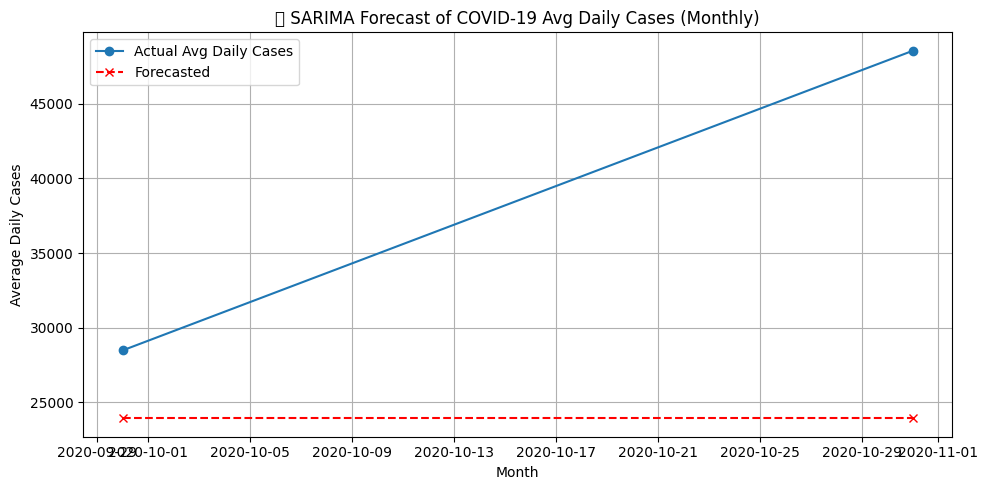

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller

# Load dataset
df = pd.read_csv("/time-series-19-covid-combined.csv")

# Preprocess
df.columns = df.columns.str.strip()
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

# Calculate daily global new cases
df_daily = df.groupby(df.index).sum(numeric_only=True)
df_daily["daily_cases"] = df_daily["Confirmed"].diff()
df_daily = df_daily.dropna(subset=["daily_cases"])

# Resample to monthly average daily cases
monthly_df = df_daily["daily_cases"].resample("M").mean().reset_index()
monthly_df.rename(columns={"Date": "month"}, inplace=True)

# Feature engineering
monthly_df['lag1'] = monthly_df['daily_cases'].shift(1)
monthly_df['lag2'] = monthly_df['daily_cases'].shift(2)
monthly_df['lag3'] = monthly_df['daily_cases'].shift(3)
monthly_df['roll_mean'] = monthly_df['daily_cases'].rolling(window=3).mean()
monthly_df['roll_std'] = monthly_df['daily_cases'].rolling(window=3).std()

# Drop NaNs
monthly_df.dropna(inplace=True)

# Stationarity check
def check_stationarity(series):
    result = adfuller(series)
    return result[1]

p_val = check_stationarity(monthly_df['daily_cases'])
if p_val > 0.05:
    monthly_df['daily_cases'] = monthly_df['daily_cases'].diff().dropna()
    monthly_df.dropna(inplace=True)

# Split into train/test
train_size = int(len(monthly_df) * 0.8)
train, test = monthly_df.iloc[:train_size], monthly_df.iloc[train_size:]

# Fit SARIMA model
sarima_model = SARIMAX(
    train['daily_cases'],
    exog=train[['lag1', 'lag2', 'lag3', 'roll_mean', 'roll_std']],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_result = sarima_model.fit(disp=False)

# Forecast
forecast_steps = len(test)
forecast = sarima_result.predict(
    start=len(train), end=len(train) + forecast_steps - 1,
    exog=test[['lag1', 'lag2', 'lag3', 'roll_mean', 'roll_std']]
)

# Evaluation
rmse = np.sqrt(mean_squared_error(test['daily_cases'], forecast))
mae = mean_absolute_error(test['daily_cases'], forecast)
mape = mean_absolute_percentage_error(test['daily_cases'], forecast) * 100
r2 = r2_score(test['daily_cases'], forecast)

print(f"📊 RMSE: {rmse:.2f}")
print(f"📊 MAE: {mae:.2f}")
print(f"📊 MAPE: {mape:.2f}%")
print(f"📊 R-squared: {r2:.4f}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(test['month'], test['daily_cases'], label="Actual Avg Daily Cases", marker="o")
plt.plot(test['month'], forecast, label="Forecasted", linestyle="--", marker="x", color="red")
plt.title("📈 SARIMA Forecast of COVID-19 Avg Daily Cases (Monthly)")
plt.xlabel("Month")
plt.ylabel("Average Daily Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')